In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import os
from collections import Counter
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [19]:
def seed_assign(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [20]:
data_path = '/data2/spike_sorting/neuropixels_choi'
filename = ["/set1/set1", "/set2/set2", "/set3/set3", "/set4/set4"]

In [21]:
index = 0 # 0-->set1, 1-->set2, 2-->set3, 3-->set4
n_unit = 7 if index != 2 else 8 # set2는 예외적으로 unit 8개다.

# method = 'mean'
# method = 'grad_offset'
method = 'neo_offset'

spike_class = f"{data_path}{filename[index]}_class_{method}.csv"
spike_raw = f"{data_path}{filename[index]}_waveform_{method}.csv"

In [22]:
# Class 파일 로드 (한 열로 저장된 값들)
with open(spike_class, "r") as f:
    class_data = np.array([int(line.strip()) for line in f])[1:]

# Waveform 파일 로드 (반점으로 구분된 행렬 형태)
waveform_data = np.loadtxt(spike_raw, delimiter=",", dtype=np.int16).T

In [23]:
print(f"{'Property':<20} | {'Value'}")
print("-" * 40)
print(f"{'Waveform Data Type':<20} | {waveform_data.dtype}")
print(f"{'Waveform Data Shape':<20} | {waveform_data.shape}")
print(f"{'Class Data Shape':<20} | {class_data.shape}")

Property             | Value
----------------------------------------
Waveform Data Type   | int16
Waveform Data Shape  | (77151, 141)
Class Data Shape     | (77151,)


In [24]:
training_spike_group_reshape = waveform_data
spike_length = waveform_data.shape[1]
training_spike_group_label_reshape = class_data.reshape(-1, 1)
print('총 스파이크 개수', training_spike_group_label_reshape.shape)

총 스파이크 개수 (77151, 1)


In [25]:
training_spike_group_reshape.shape

(77151, 141)

In [26]:
# 좀 자르자 70개 너무 많다.
spike_exact = 70 # matlab에서 crop할 때 70의 index가 ground truth timing임.
want_to_look_just_n_sample = 30 # max: 140 # 니가 140개만 뽑았잖아 141개도되나?
training_spike_group_reshape_sliced = training_spike_group_reshape[:, spike_exact - want_to_look_just_n_sample//2:spike_exact - want_to_look_just_n_sample//2 + want_to_look_just_n_sample]

In [27]:
training_spike_group_reshape_sliced.shape

(77151, 30)

## Hyperparameter


In [28]:
# hyperparameter

my_seed = 42
seed_assign(my_seed)

batch_size = 64
epoch = 20
learning_rate = 0.001

what_data = 'quiroga' # 'quiroga' or 'n2016'
n_sample = 50
normalize_on = True # True or False

if what_data == 'n2016':
    assert want_to_look_just_n_sample == n_sample
if what_data == 'quiroga':
    assert n_sample == 50

In [29]:

# Autoencoder 모델 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(n_sample, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, n_sample),
            nn.Sigmoid()  # 출력값을 0-1 사이로 제한
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    

dataset

In [30]:

if what_data == 'quiroga':

    ########Quiroga 데이터셋###############################################################################
    class Qurioga_Spike(Dataset):
        def __init__(self, root = '/data2/spike_sorting/quiroga/', train = True):
            # root = '/data2/spike_sorting/quiroga/'
            if train == True:
                root = root + 'train/'
                # 데이터 로드
                train_data_loaded = torch.load(root + 'data.pt')
                train_label_loaded = torch.load(root + 'label.pt')

                # 데이터 타입 변환
                self.data = train_data_loaded.to(torch.float32)  # train_data를 float32로 변환
                self.labels = train_label_loaded.to(torch.long)  # train_label을 long으로 변환
            else:
                root = root + 'test/'
                # 데이터 로드
                test_data_loaded = torch.load(root + 'data.pt')
                test_label_loaded = torch.load(root + 'label.pt')

                # 데이터 타입 변환
                self.data = test_data_loaded.to(torch.float32)
                self.labels = test_label_loaded.to(torch.long) 

            if normalize_on == True:
                data_np = self.data.numpy()
                self.scaler = StandardScaler()
                self.data = torch.tensor(self.scaler.fit_transform(data_np), dtype=torch.float32)
            

            self.class_num = max(self.labels).item()

        def __len__(self):
            return len(self.data)  # 데이터의 크기 반환

        def __getitem__(self, idx):
            return self.data[idx], self.labels[idx]  # 주어진 인덱스에 해당하는 데이터와 레이블 반환

        
    # 데이터셋 준비
    train_dataset = Qurioga_Spike(root='/data2/spike_sorting/quiroga/', train=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = Qurioga_Spike(root='/data2/spike_sorting/quiroga/', train=False)
    test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    #######################################################################################################

elif what_data == 'n2016':
    ######## N2016 데이터셋################################################################################
    spike_data = torch.from_numpy(training_spike_group_reshape_sliced).float()
    labels = torch.from_numpy(class_data).long()  # 라벨 데이터는 Long 타입으로 변환
    labels = labels - 1 # matlab은 1부터 시작하니까 1 빼줌.
    
    if normalize_on == True:
        scaler = StandardScaler()
        spike_data = torch.from_numpy(scaler.fit_transform(spike_data)).float()
    
    train_dataset = TensorDataset(spike_data, labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    #######################################################################################################

else:
    assert False, "what_data를 다시 봐주세요."

total_train_spike_num = train_dataset.__len__()
print('총 스파이크 개수', total_train_spike_num)
print('len(train_loader):',len(train_loader))


총 스파이크 개수 38400
len(train_loader): 600


In [31]:

# Loss 기록을 저장할 리스트
loss_history = []

# device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:',device)


# 모델 초기화
model = Autoencoder().to(device)

# 손실 함수 및 최적화 함수 설정
criterion = nn.MSELoss()  # 평균 제곱 오차 (Mean Squared Error)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 학습 함수
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs, lbls = data
            inputs, lbls = inputs.to(device), lbls.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  # Autoencoder의 목적은 입력을 재구성하는 것
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)  # Loss 기록 저장
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# 모델 학습
train(model, train_loader, criterion, optimizer, epochs=epoch)

Device: cuda
Epoch [1/20], Loss: 0.7463
Epoch [2/20], Loss: 0.6678
Epoch [3/20], Loss: 0.6526
Epoch [4/20], Loss: 0.6478
Epoch [5/20], Loss: 0.6447
Epoch [6/20], Loss: 0.6429
Epoch [7/20], Loss: 0.6416
Epoch [8/20], Loss: 0.6407
Epoch [9/20], Loss: 0.6398
Epoch [10/20], Loss: 0.6391
Epoch [11/20], Loss: 0.6386
Epoch [12/20], Loss: 0.6383
Epoch [13/20], Loss: 0.6380
Epoch [14/20], Loss: 0.6378
Epoch [15/20], Loss: 0.6377
Epoch [16/20], Loss: 0.6374
Epoch [17/20], Loss: 0.6372
Epoch [18/20], Loss: 0.6371
Epoch [19/20], Loss: 0.6369
Epoch [20/20], Loss: 0.6368


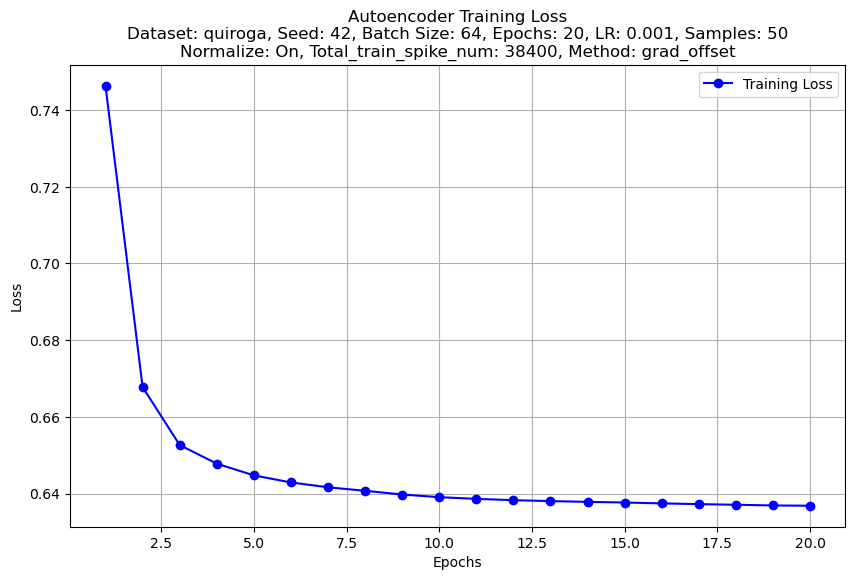

In [32]:
# Loss 그래프 그리기
def plot_loss(loss_history, title_info):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o', color='blue', label='Training Loss')
    plt.title(
        f"Autoencoder Training Loss\n"
        f"Dataset: {title_info['what_data']}, Seed: {title_info['my_seed']}, "
        f"Batch Size: {title_info['batch_size']}, Epochs: {title_info['epoch']}, "
        f"LR: {title_info['learning_rate']}, Samples: {title_info['n_sample']}\n"
        f"Normalize: {title_info['normalize_on']}, "
        f"Total_train_spike_num: {title_info['total_train_spike_num']}, "
        f"Method: {title_info['method']}"
    )
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

if what_data == 'n2016':
    what_data = f"{what_data} Set{index + 1}"
if what_data == 'quiroga':
    method = 'grad_offset'

# 플롯에 필요한 정보 정의
title_info = {
    "what_data": what_data,
    "my_seed": my_seed,
    "batch_size": batch_size,
    "epoch": epoch,
    "learning_rate": learning_rate,
    "n_sample": n_sample,  # Train 데이터 샘플 수
    "normalize_on": "On" if normalize_on else "Off",  # 정규화 상태
    "total_train_spike_num": total_train_spike_num,
    "method": method
}

# Loss 그래프 호출
plot_loss(loss_history, title_info)


Number of Classes: 3, Classes: [0 1 2]


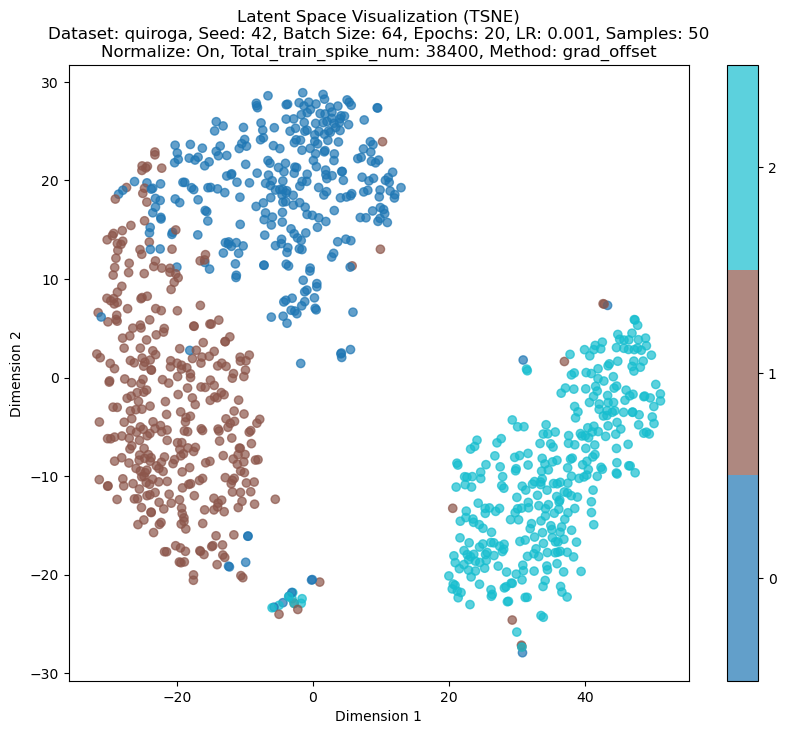

In [33]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_latent_space(model, data_loader, n_samples=1000, method="PCA"):
    model.eval()
    latent_representations = []
    labels = []
    with torch.no_grad():
        for data in data_loader:
            inputs, lbls = data
            inputs, lbls = inputs.to(device), lbls.to(device)

                    # 라벨이 3 이상인 경우 제외
            mask = lbls < 3  # 라벨이 3 미만인 경우 True
            inputs = inputs[mask]
            lbls = lbls[mask]

            latent = model.encoder(inputs)  # Latent representation 얻기
            latent_representations.append(latent.cpu().numpy())



            labels.extend(lbls.cpu().numpy())
            if len(labels) >= n_samples:
                break

    latent_representations = np.concatenate(latent_representations, axis=0)[:n_samples]
    labels = np.array(labels[:n_samples])

    # 차원 축소
    if method == "PCA":
        reducer = PCA(n_components=2)
    elif method == "TSNE":
        reducer = TSNE(n_components=2, random_state=my_seed)
    else:
        raise ValueError("method must be 'PCA' or 'TSNE'")
    
    reduced_data = reducer.fit_transform(latent_representations)

    # 시각화
    plt.figure(figsize=(10,8))
    unique_classes = np.unique(labels)
    n_classes = len(unique_classes)
    print(f"Number of Classes: {n_classes}, Classes: {unique_classes}")

    cmap = plt.get_cmap("tab20", n_classes) if n_classes > 10 else plt.get_cmap("tab10", n_classes)
    scatter = plt.scatter(
        reduced_data[:, 0],
        reduced_data[:, 1],
        c=labels,
        cmap=cmap,  # 동적으로 클래스 수에 맞는 cmap 생성
        alpha=0.7
    )
    # plt.colorbar(scatter, ticks=range(n_classes))  # 클래스 개수에 맞는 colorbar 생성

    # Colorbar 설정
    cbar = plt.colorbar(scatter)
    ticks = np.arange(n_classes)*(n_classes-1)/(n_classes) +  (n_classes-1)/(2*n_classes) # 색상의 중심에 위치하도록 tick 값 조정
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(unique_classes)  # 클래스 값으로 tick 레이블 설정
   

    plt.title(
        f"Latent Space Visualization ({method})\n"
        f"Dataset: {title_info['what_data']}, Seed: {title_info['my_seed']}, "
        f"Batch Size: {title_info['batch_size']}, Epochs: {title_info['epoch']}, "
        f"LR: {title_info['learning_rate']}, Samples: {title_info['n_sample']}\n"
        f"Normalize: {title_info['normalize_on']}, "
        f"Total_train_spike_num: {title_info['total_train_spike_num']}, "
        f"Method: {title_info['method']}"
    )


    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

# Latent Space 시각화 (Train 데이터)
visualize_latent_space(model, train_loader, method="TSNE")


Number of Classes: 12, Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11]


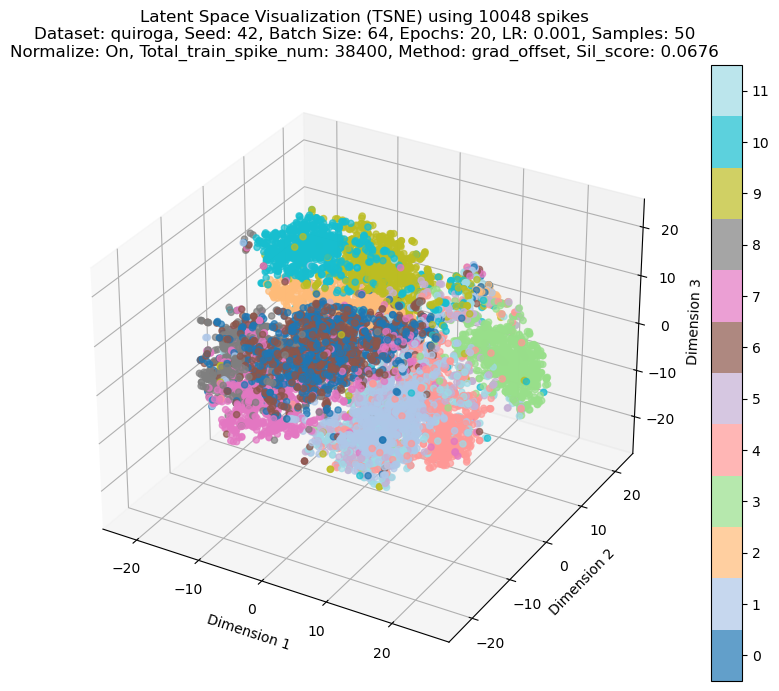

Silhouette Score: 0.06759820878505707


In [34]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score

def visualize_latent_space(model, data_loader, n_samples=10000, method="PCA"):
    model.eval()
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for data in data_loader:
            inputs, lbls = data
            inputs, lbls = inputs.to(device), lbls.to(device)

            # # 라벨이 3 이상인 경우 제외
            # mask = lbls < 3  # 라벨이 3 미만인 경우 True
            # inputs = inputs[mask]
            # lbls = lbls[mask]

            latent = model.encoder(inputs)  # Latent representation 얻기
            latent_representations.append(latent.cpu().numpy())
            labels.extend(lbls.cpu().numpy())
            if len(labels) >= n_samples:
                break
        
    n_samples_real = len(labels)
    if n_samples_real > n_samples:
        latent_representations = np.concatenate(latent_representations, axis=0)[:n_samples]
        labels = np.array(labels[:n_samples])
    else:
        latent_representations = np.concatenate(latent_representations, axis=0)
        labels = np.array(labels)

    sil_score = silhouette_score(latent_representations, labels) # 이 값은 -1에서 1까지의 범위를 가지며, 값이 1에 가까울수록 좋습니다.

    # 차원 축소 (3차원)
    if method == "PCA":
        reducer = PCA(n_components=3)
    elif method == "TSNE":
        reducer = TSNE(n_components=3, random_state=my_seed)
    else:
        raise ValueError("method must be 'PCA' or 'TSNE'")
    
    reduced_data = reducer.fit_transform(latent_representations)

    # 3D 시각화
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    unique_classes = np.unique(labels)
    n_classes = len(unique_classes)
    
    print(f"Number of Classes: {n_classes}, Classes: {unique_classes}")

    cmap = plt.get_cmap("tab20", n_classes) if n_classes > 10 else plt.get_cmap("tab10", n_classes)
    scatter = ax.scatter(
        reduced_data[:, 0],
        reduced_data[:, 1],
        reduced_data[:, 2],
        c=labels,
        cmap=cmap,
        alpha=0.7
    )

    # Colorbar 설정
    cbar = plt.colorbar(scatter)
    ticks = np.arange(n_classes)*(n_classes-1)/(n_classes) + (n_classes-1)/(2*n_classes)  # 색상의 중심에 위치하도록 tick 값 조정
    cbar.set_ticks(ticks)
    cbar.set_ticklabels(unique_classes)  # 클래스 값으로 tick 레이블 설정

    plt.title(
        f"Latent Space Visualization ({method}) using {n_samples_real} spikes\n"
        f"Dataset: {title_info['what_data']}, Seed: {title_info['my_seed']}, "
        f"Batch Size: {title_info['batch_size']}, Epochs: {title_info['epoch']}, "
        f"LR: {title_info['learning_rate']}, Samples: {title_info['n_sample']}\n"
        f"Normalize: {title_info['normalize_on']}, "
        f"Total_train_spike_num: {title_info['total_train_spike_num']}, "
        f"Method: {title_info['method']}, "
        f"Sil_score: {sil_score:.4f}"
    )

    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    plt.show()


    print(f"Silhouette Score: {sil_score}")


# Latent Space 시각화 (Train 데이터)
visualize_latent_space(model, train_loader, method="TSNE")
 